### Instalando librerias

In [9]:
# import pyspark modules

from pyspark.sql.functions import udf, lower, col, regexp_replace, concat_ws, collect_list
from pyspark.sql.types import StructType, ArrayType, StringType

#Load the librarys

import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn


# standard modules
import re
from datetime import datetime

In [15]:
from pyspark.sql import SparkSession
import pandas as pd #To work with dataset
import numpy as np #Math library


In [8]:
# start session
spark = SparkSession.builder.appName("Analysis").getOrCreate()

In [ ]:
#downloading data
input_loc = '/Users/52667/Documents/Airflow-P2/00_input_data/german_credit_data.csv'
df_credit = spark.read.option("header", True).csv(input_loc)

In [24]:
df_credit=pd.read_csv('/Users/52667/Documents/Airflow-P2/00_input_data/german_credit_data.csv',index_col=0)

In [4]:
#Searching for Missings,type of data and also known the shape of data
print(df_credit.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB
None


In [25]:
#Looking unique values
print(df_credit.nunique())
#Looking the data
print(df_credit.head())

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64
   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  
0         6             radio/TV  
1        48             radio/TV  
2        12            education  
3        42  furniture/equipment  
4        24                  car  


In [26]:
print(pd.crosstab(df_credit["Checking account"],df_credit.Sex))

Sex               female  male
Checking account              
little                88   186
moderate              86   183
rich                  20    43


In [10]:
date_int = ["Purpose", 'Sex']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(df_credit[date_int[0]], df_credit[date_int[1]]).style.background_gradient(cmap = cm)

Sex,female,male
Purpose,,
business,19,78
car,94,243
domestic appliances,6,6
education,24,35
furniture/equipment,74,107
radio/TV,85,195
repairs,5,17
vacation/others,3,9


In [27]:
date_int = ["Purpose", 'Sex']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(df_credit[date_int[0]], df_credit[date_int[1]]).style.background_gradient(cmap = cm)

Sex,female,male
Purpose,,
business,19,78
car,94,243
domestic appliances,6,6
education,24,35
furniture/equipment,74,107
radio/TV,85,195
repairs,5,17
vacation/others,3,9


In [30]:
# Looking the total of values in each categorical feature

print("Purpose : ",df_credit.Purpose.unique())
print("Sex : ",df_credit.Sex.unique())
print("Housing : ",df_credit.Housing.unique())
print("Saving accounts : ",df_credit['Saving accounts'].unique())
#print("Risk : ",df_credit['Risk'].unique())
print("Checking account : ",df_credit['Checking account'].unique())
#print("Aget_cat : ",df_credit['Age_cat'].unique())

Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Sex :  ['male' 'female']
Housing :  ['own' 'free' 'rent']
Saving accounts :  [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account :  ['little' 'moderate' nan 'rich']


In [31]:
# Let's do some feature engineering on this values and create variable Dummies of the values

def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [32]:
# Transforming the data into Dummy variables

df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

#Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Sex feature in dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
#df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
# df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

In [ ]:
# Deleting the old features

#Excluding the missing columns
del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
del df_credit["Sex"]
del df_credit["Housing"]
del df_credit["Age_cat"]
del df_credit["Risk"]
del df_credit['Risk_good']

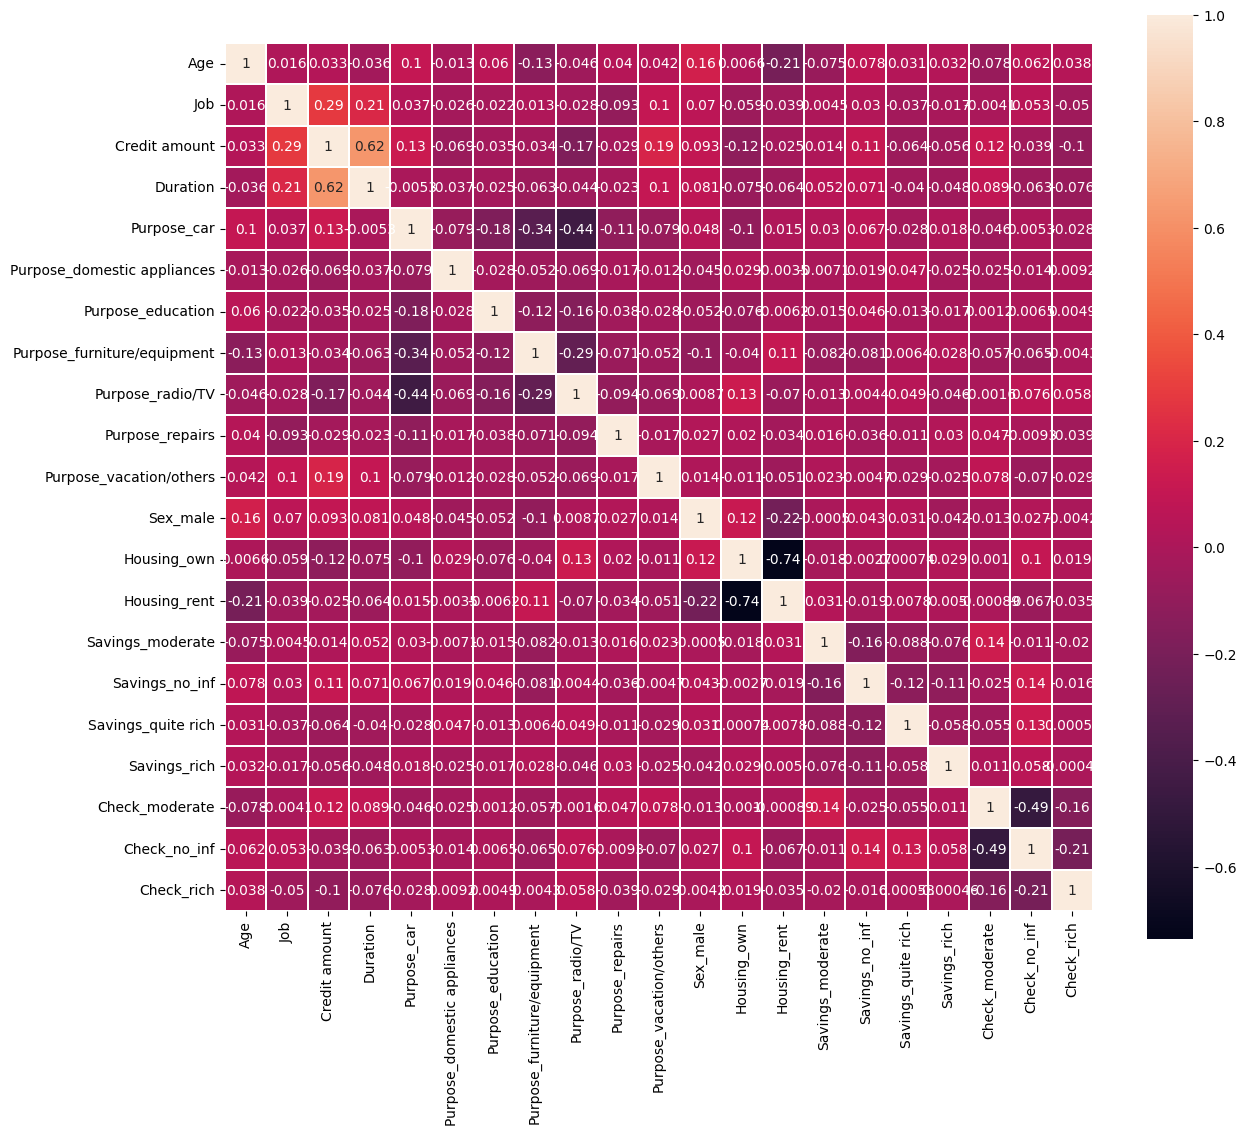

In [37]:
# 5.- Correlation
# Looking the data correlation

plt.figure(figsize=(14,12))
sns.heatmap(df_credit.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

In [ ]:
# 6 .- Pre Processing

# Importing ML librarys
# Setting X and y variables to the prediction
# Splitting Data

from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
df_credit['Credit amount'] = np.log(df_credit['Credit amount'])

#Creating the X and y variables
X = df_credit.drop('Risk_bad', 1).values
y = df_credit["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)


In [ ]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:


# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# 7.- Models

# Using Random Forest to predictict the credit score
# Some of Validation Parameters

#Seting the Hyper Parameters
param_grid = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,25,50,150],
              "max_features": [4,7,15,20]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=4)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
rf = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=15, random_state=2)

#trainning with the best params
rf.fit(X_train, y_train)

In [ ]:
#Testing the model 
#Predicting using our  model
y_pred = rf.predict(X_test)

# Verificaar os resultados obtidos
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(fbeta_score(y_test, y_pred, beta=2))

In [ ]:
# 7.2 Model 2

from sklearn.utils import resample
from sklearn.metrics import roc_curve

# Criando o classificador logreg
GNB = GaussianNB()

# Fitting with train data
model = GNB.fit(X_train, y_train)

# Printing the Training Score
print("Training score data: ")
print(model.score(X_train, y_train))

In [ ]:
y_pred = model.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

In [ ]:
# Let's verify the ROC curve¶

#Predicting proba
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

In [ ]:
features = []
features.append(('pca', PCA(n_components=2)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)
# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', GaussianNB()))
model = Pipeline(estimators)
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(fbeta_score(y_test, y_pred, beta=2))

In [ ]:
# Implementing a pipeline of models

#Seting the Hyper Parameters
param_test1 = {
 'max_depth':[3,5,6,10],
 'min_child_weight':[3,5,10],
 'gamma':[0.0, 0.1, 0.2, 0.3, 0.4],
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10],
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

#Creating the classifier
model_xg = XGBClassifier(random_state=2)

grid_search = GridSearchCV(model_xg, param_grid=param_test1, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_score_
grid_search.best_params_

In [ ]:
y_pred = grid_search.predict(X_test)

# Verificaar os resultados obtidos
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))